In [ ]:
pip install catboost

In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from scipy.stats import gaussian_kde
from scipy.stats import randint, uniform

In [ ]:
import optuna

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
from catboost import CatBoostClassifier
import xgboost as xgb_model
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [ ]:
from imblearn.combine import SMOTETomek

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv('/content/Dataset.csv')

In [ ]:
drop_cols = ['Patient Id', 'Patient First Name', 'Family Name', "Father's name",
             'Institute Name', 'Location of Institute', 'Disorder Subclass']

In [ ]:
df.drop(columns=drop_cols, inplace=True)

In [ ]:
df = df[df['Genetic Disorder'].notna()]

In [ ]:
# STEP 5: Separate features and target
X = df.drop('Genetic Disorder', axis=1)
y = df['Genetic Disorder']

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
y = label_encoder.fit_transform(y)

In [ ]:
# STEP 6: Identify column types
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include='number').columns.tolist()

In [ ]:
# STEP 7: Preprocessing pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

In [ ]:
X_processed = preprocessor.fit_transform(X)

In [ ]:
X_resampled, y_resampled = SMOTETomek(random_state=42).fit_resample(X_processed, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

### **Model 1: CatBoost**

---



In [ ]:
cat_model = CatBoostClassifier(
    iterations=1000, depth=6, learning_rate=0.05, auto_class_weights="Balanced", random_state=42, verbose=100
)

In [ ]:
cat_model.fit(X_train, y_train)

0:	learn: 1.0744189	total: 179ms	remaining: 2m 59s
100:	learn: 0.6717393	total: 8.88s	remaining: 1m 19s
200:	learn: 0.6211178	total: 15.2s	remaining: 1m
300:	learn: 0.5885377	total: 22.7s	remaining: 52.7s
400:	learn: 0.5628837	total: 28.7s	remaining: 42.9s
500:	learn: 0.5389574	total: 36.2s	remaining: 36s
600:	learn: 0.5166802	total: 42.3s	remaining: 28.1s
700:	learn: 0.4964917	total: 49.7s	remaining: 21.2s
800:	learn: 0.4767662	total: 55.8s	remaining: 13.9s
900:	learn: 0.4596495	total: 1m 3s	remaining: 6.95s
999:	learn: 0.4432649	total: 1m 9s	remaining: 0us


In [ ]:
y_pred_cat = cat_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_cat))

              precision    recall  f1-score   support

           0       0.66      0.80      0.72      1909
           1       0.83      0.89      0.86      2040
           2       0.69      0.50      0.58      1910

    accuracy                           0.73      5859
   macro avg       0.73      0.73      0.72      5859
weighted avg       0.73      0.73      0.72      5859



### **Model 2: Random Forest**

---



In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=200, max_depth=10, min_samples_split=5, class_weight="balanced", random_state=42
)

In [ ]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, n_estimators=200, random_state=42)

In [ ]:
y_pred_rf = rf_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.63      0.87      0.73      1909
           1       0.77      0.91      0.83      2040
           2       0.77      0.33      0.46      1910

    accuracy                           0.71      5859
   macro avg       0.72      0.70      0.68      5859
weighted avg       0.72      0.71      0.68      5859



### **Model 3: XGBoost**

---



In [ ]:
# Define class weights
class_weights = {0: 1.0, 1: 10_202/2_071, 2: 10_202/7_664}
sample_weights = [class_weights[label] for label in y_train]

In [ ]:
xgb_model = xgb_model.XGBClassifier(
    n_estimators=200, max_depth=6, learning_rate=0.05, subsample=0.8, use_label_encoder=False,
    eval_metric="mlogloss", random_state=42
)

In [ ]:
xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:19:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred_xgb = xgb_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.70      0.61      0.65      1909
           1       0.70      0.96      0.81      2040
           2       0.61      0.45      0.52      1910

    accuracy                           0.68      5859
   macro avg       0.67      0.67      0.66      5859
weighted avg       0.67      0.68      0.66      5859



### **Model 4: LightGBM**

---



In [ ]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=200, max_depth=6, learning_rate=0.05, class_weight="balanced", random_state=42
)

In [ ]:
lgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15555
[LightGBM] [Info] Number of data points in the train set: 23433, number of used features: 61
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=6,
               n_estimators=200, random_state=42)

In [ ]:
y_pred_lgb = lgb_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
print(classification_report(y_test, y_pred_lgb))

              precision    recall  f1-score   support

           0       0.63      0.80      0.71      1909
           1       0.82      0.88      0.85      2040
           2       0.67      0.44      0.53      1910

    accuracy                           0.71      5859
   macro avg       0.71      0.71      0.69      5859
weighted avg       0.71      0.71      0.70      5859



### **Model 5: Logistic Regression**

---



In [ ]:
lr_model = LogisticRegression(
    C=0.1, class_weight="balanced", multi_class="multinomial", solver="lbfgs", max_iter=1000, random_state=42
)

In [ ]:
lr_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', random_state=42)

In [ ]:
y_pred_lr = lr_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.56      0.39      0.46      1909
           1       0.68      0.89      0.77      2040
           2       0.44      0.43      0.44      1910

    accuracy                           0.58      5859
   macro avg       0.56      0.57      0.56      5859
weighted avg       0.56      0.58      0.56      5859



### **Model 6: Support Vector Machine (SVM)**

---



In [ ]:
svm_model = SVC(C=1.0, kernel="rbf", class_weight="balanced", random_state=42)

In [ ]:
svm_model.fit(X_train, y_train)

SVC(class_weight='balanced', random_state=42)

In [ ]:
y_pred_svm = svm_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.65      0.76      0.70      1909
           1       0.83      0.93      0.88      2040
           2       0.71      0.49      0.58      1910

    accuracy                           0.73      5859
   macro avg       0.73      0.73      0.72      5859
weighted avg       0.73      0.73      0.72      5859



### **Model 7: Neural Network (ANN)**

---



In [ ]:
X_train.shape

(23433, 67)

In [ ]:
Early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [ ]:
model = Sequential()

In [ ]:
model.add(Input(shape=(67, )))

In [ ]:
model.add(Dense(67, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(33, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(9, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=X_train, y=y_train,
          validation_data=(X_test, y_test),
          batch_size=128, epochs=600, callbacks=[Early_stop])

Epoch 1/600
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.3230 - loss: 1.6409 - val_accuracy: 0.4235 - val_loss: 1.0552
Epoch 2/600
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3751 - loss: 1.1852 - val_accuracy: 0.5501 - val_loss: 0.9543
Epoch 3/600
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4264 - loss: 1.0692 - val_accuracy: 0.5905 - val_loss: 0.9002
Epoch 4/600
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4756 - loss: 1.0098 - val_accuracy: 0.5880 - val_loss: 0.8754
Epoch 5/600
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5035 - loss: 0.9794 - val_accuracy: 0.5934 - val_loss: 0.8587
Epoch 6/600
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5293 - loss: 0.9578 - val_accuracy: 0.5960 - val_loss: 0.8465
Epoch 7/600
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5450 - loss: 0.9379 - val_accuracy: 0.5981 - val_loss: 0.8373
Epoch 8/600
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5551 - loss: 0.9280 - val_accu

In [ ]:
model_loss = pd.DataFrame(model.history.history)

<Axes: >

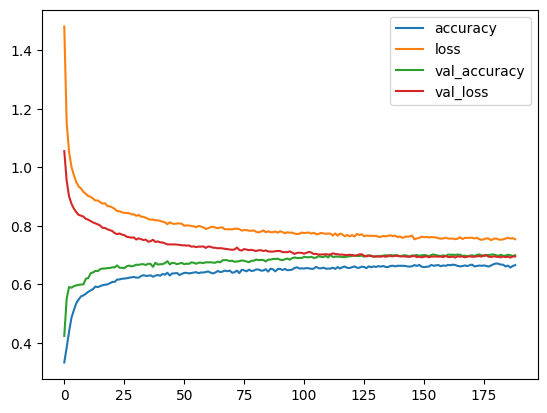

In [ ]:
model_loss.plot()

In [ ]:
model.evaluate(X_test, y_test)

184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7012 - loss: 0.6861


[0.695019006729126, 0.698924720287323]

In [ ]:
predict = model.predict(X_test)

184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
predict[0]

array([0.38933027, 0.04452565, 0.5661441 ], dtype=float32)

In [ ]:
np.argmax(predict[0])

np.int64(2)

In [ ]:
predict_label = [np.argmax(i) for i in predict]

In [ ]:
print(classification_report(y_test, predict_label))

              precision    recall  f1-score   support

           0       0.65      0.76      0.70      1909
           1       0.81      0.87      0.84      2040
           2       0.61      0.46      0.53      1910

    accuracy                           0.70      5859
   macro avg       0.69      0.70      0.69      5859
weighted avg       0.69      0.70      0.69      5859

